### librerie

In [1]:
#!pip install yfinance --upgrade --no-cache-dir

In [6]:
from scipy.stats import skew
import numpy as np
import pandas as pd
from pandas_datareader import data as wb
import matplotlib.pyplot as plt
import cufflinks as cf
cf.go_offline()
import chart_studio as cs
from IPython.display import display, HTML
import yfinance as yf
from datetime import datetime, date
import seaborn as sns
%matplotlib inline
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

### Funzioni

funzione per creare i dataframe per i valori giornalieri di chiusura e i dividendi ""giornalieri""

In [8]:
def table(assets,start_date,end_date):
    #Dataframe per valori di chiusura
    pf_data = pd.DataFrame()
    #Dataframe per i dividendi
    date_today = datetime.now()
    days = pd.date_range(start_date, end_date , freq='D')
    pf_div = pd.DataFrame(index = days)

    #Riempio il dataframe pf_data con le diverse stock
    for a in assets:
        pf_data[a]= wb.DataReader(a,data_source='yahoo', start = start_date , end= end_date)['Adj Close']

    #Riempio il dataframe pf_div con i dividendi delle stock
    for a in range(len(assets)):

        stock = yf.Ticker(assets[a])
        pf_div[assets[a]]=stock.dividends


    pf_div = pf_div.dropna(how='all') #cancella le righe che sono tutte NaN
    pf_div.fillna(0, inplace=True) # trasmormo Nan in 0 per fare calcoli
    return pf_data,pf_div

Funzione per calcolare il ritorno giornaliero e su quello calcolare riorno medio annuo, volatilità media, dividendi medi ecc

In [9]:
def basic_analysis(pf_data, pf_div): 
    #calcolo ritorno logaritmico gioraliero degli assets mel periodo selezionato
    log_returns =np.log(pf_data/pf_data.shift(1))
    #percentuale di ritorno annua media di ogni stocks
    mean_annual_return = round(log_returns.mean()*250*100,1)
    #percentuale di volatilità annua media di ogni stock
    mean_annual_volatility = round(log_returns.std()*250**0.5*100,1) 
    #valore dei dividendi medio annua per ogni stock
    mean_annual_dividend = round((pd.DataFrame(pf_div.resample('Y').sum())).mean(),2)
    # rapporto tra prezzo stock e i suoi dividendi
    dividends_stock = round((mean_annual_dividend / pf_data.values[len(pf_data)-1])*100,2)
    # PROBLEMA se prendo un anno ancora non completo mi si sfancula tutto
    # IPOTESI FORTE prendo solo dati da inzio anno fino a fine anno
    div = pf_div.resample('Y').sum()
    tasso_crescita = ((div-div.shift(1))/div)
    tasso_crescita = tasso_crescita.iloc[1:]# cancello prima riga fatta di nan
    tasso_return = round(tasso_crescita.mean()*100,2)
    tasso_vol = round(tasso_crescita.std()*100**0.5,2)
    
    #Creo Dataframe per un review veloce
    review = pd.DataFrame(index = assets)
    review['Mean annual Return [%]'] = mean_annual_return
    review['Mean annual Volatility [%]'] = mean_annual_volatility
    review['Mean annual Dividends [$/N°stock]'] = mean_annual_dividend
    review['Dividends / Stock price (actual)'] = dividends_stock
    review['Tasso annuo crescita dividendi [%]'] = tasso_return
    review['Tasso annuo volatilità dividendi [%]'] = tasso_vol
    return review

Funzione che grafica la correlazione tra le stocks

In [10]:
def correlation():
    #cambia center per capire meglio la correlazione 
    log_returns =np.log(pf_data/pf_data.shift(1))
    correlation = log_returns.corr()
    mask = np.zeros_like(correlation)
    mask[np.triu_indices_from(mask)] = True
    plt.subplots(figsize=(10,10))
    p = sns.heatmap(correlation,center=0.5,annot=True,mask=mask);
    return p

Funzione che genera diverse combinazioni di pesi di portafoglio

In [58]:
def montecarlo(n_port, assets, pf_div, pf_data):
    #genero tot combinazioni di peso per il tuo portafoglio (nel ciclo for inserisci il n combinazioni) per
    #valutare tutte le possibili combinazioni di peso, scegliendo poi quella ottima
    num_assets=len(assets)
    pfoglio_returns=[]
    pfoglio_volatilities=[]
    pfoglio_weights=[]
    pfoglio_sharpe_ratio = []
    pfoglio_dividends = []
    pfoglio_sharpe_yield = []
    risk_free = 0.025 #bot 10 anni US collegare a yahoo
    stock_value = (pf_data.values[0]) #valore della stock allo start_date
                                      #verificare che il primo valore non sia un NaN 
    
    log_returns =np.log(pf_data/pf_data.shift(1))
    np.random.seed(1373)
    for x in range (n_port):

        weights=np.random.random(num_assets)
        weights/=np.sum(weights)
        weights = np.around(weights,4)
        returns = np.around(np.sum(weights* log_returns.mean())*250,4)  
        volatility = np.around(np.sqrt(np.dot(weights.T, np.dot(log_returns.cov()*250,weights))),4)
        sharpe_ratio = np.around((returns - risk_free)/volatility,2)
        n_stocks = capitale*weights/stock_value
        dividends = np.around(np.sum((pf_div*n_stocks).sum(axis = 0)),2)
        sharpe_yield = np.round(sharpe_ratio/dividends,3) #indicatore per trovare il miglior rapporto sharpe_divid

        pfoglio_weights.append(weights)
        pfoglio_returns.append(returns)
        pfoglio_volatilities.append(volatility)
        pfoglio_sharpe_ratio.append(sharpe_ratio)
        pfoglio_dividends.append(dividends)
        pfoglio_sharpe_yield.append(sharpe_yield)


    portfoglios=pd.DataFrame({'Return': pfoglio_returns, 'Volatility': pfoglio_volatilities,
                              'Sharpe Ratio': pfoglio_sharpe_ratio, 'Dividends': pfoglio_dividends,
                              'Sharpe Yield': pfoglio_sharpe_yield})
    portfoglios=pd.concat([portfoglios, pd.DataFrame(pfoglio_weights)], axis=1);
    columns_name = [ 'Returns', 'Volatility','Sharpe Ratio', 'Dividends', 'Sharpe Yield'] + ["Weight_" + assets for assets in assets]
    portfoglios.columns= columns_name
    return portfoglios

Funzione per plottare la curva di markovitz dei portafogli

In [57]:
def markowitz(portfoglios):
    min_volatility = portfoglios['Volatility'].min()
    max_sharpe = portfoglios['Sharpe Ratio'].max()
    max_dividends = portfoglios['Dividends'].max()
    #max_yield = portfoglios['Dividends'].max()
    #max_yieldsharpe = portfoglios['Sharpe Yield'].max()

    # use the min, max values to locate and create the two special portfolios
    sharpe_portfolio = portfoglios.loc[portfoglios['Sharpe Ratio'] == max_sharpe]
    min_volatility_sharpe = sharpe_portfolio['Volatility'].min()
    sharpe_portfolio = sharpe_portfolio.loc[sharpe_portfolio['Volatility'] == min_volatility_sharpe]
    min_variance_port = portfoglios.loc[portfoglios['Volatility'] == min_volatility]
    max_dividends = min_variance_port['Dividends'].max()
    min_variance_port = min_variance_port.loc[min_variance_port['Dividends'] == max_dividends]
    #dividends_port = portfoglios.loc[portfoglios['Dividends'] == max_yield]
    #maximize_sharpeyield_port = portfoglios.loc[portfoglios['Sharpe Yield'] == max_yieldsharpe]

    # PLOT
    plt.style.use('seaborn-dark')
    portfoglios.plot( x='Volatility', y='Returns', kind='scatter',figsize=(10,6),
                      edgecolors='black',grid=True);
    plt.scatter(x=sharpe_portfolio['Volatility'], y=sharpe_portfolio['Returns'], 
                c='red', marker='D', s=100 , label = 'Portafoglio sharpe');
    plt.scatter(x=min_variance_port['Volatility'], y=min_variance_port['Returns'], 
                c='blue', marker='D', s=50, label = 'Portafoglio volatilità minima');
    #plt.scatter(x= dividends_port['Volatility'], y= dividends_port['Returns'], 
    #            c='yellow', marker='D', s=50, label = 'Portafoglio dividendi massimi');
    #plt.scatter(x= maximize_sharpeyield_port['Volatility'], y= maximize_sharpeyield_port['Returns'], 
    #            c='green', marker='D', s=50, label = 'Portafoglio yield sharpe');
    plt.legend();
    
    #tabella soldi
    weight_sharpe = sharpe_portfolio.iloc[:, 5:(len(assets)+5)]
    weight_minvar = min_variance_port.iloc[:, 5:(len(assets)+5)] # +5 per aggiungere le prime 5 colonne
    review = pd.DataFrame(index = assets)
    review['Weight Sharpe Portfolio [$]'] = np.around(weight_sharpe.values[0]*capitale,1) 
    review['Weight Min Variance Portfolio [$]'] = np.around(weight_minvar.values[0]*capitale,1) 
    sharpe_portfolio.round(2)
    display(review)
    #concateno i due dataframe
    frames = [sharpe_portfolio, min_variance_port]
    result = pd.concat(frames)
    display(result)
    money_sharpe = weight_sharpe.values[0]*capitale
    money_vol = weight_minvar.values[0]*capitale
    return money_sharpe, money_vol, sharpe_portfolio, min_variance_port

Funzione per plottare equity dei portafogli 

In [13]:
def portfolio_plot(pf_data, money_sharpe, money_vol):
    log_returns =np.log(pf_data/pf_data.shift(1))
    equity_sharpe = pd.DataFrame(log_returns)
    equity_sharpe.iloc[0] = money_sharpe
    sharpe = equity_sharpe.copy()
    for i in range(1,len(equity_sharpe)):
        sharpe.iloc[i] = sharpe.iloc[i-1]*sharpe.iloc[i] + sharpe.iloc[i-1]
    sharpe_equity = sharpe.copy()


    equity_minvar = pd.DataFrame(log_returns)
    equity_minvar.iloc[0] = money_vol
    minvar = equity_minvar.copy()
    for j in range(1,len(equity_minvar)):    
        minvar.iloc[j] = minvar.iloc[j-1]*minvar.iloc[j] + minvar.iloc[j-1]
    minvar_equity = minvar.copy()

    somma = pd.DataFrame({'Equity Sharpe[$]':sharpe_equity.sum(axis = 1), 
                          'Equity Min Volatility[$]': minvar_equity.sum(axis = 1)})
    
    plt.style.use('seaborn-dark')
    p = somma.plot(grid=True, figsize=(10,6));
    return p

Funzione utilizzata per la validazione

In [96]:
def validation(assets,end_date,sharpe_portfolio,min_variance_port):
    nport = 5000 #non ne servono tanti per la validazione
    #estrapolo i dati dal end date in poi 
    pf_data_validation = pd.DataFrame()
    #Dataframe per i dividendi
    date_today = datetime.now()
    days = pd.date_range(start_date, date_today , freq='D')
    pf_div_validation = pd.DataFrame(index = days)

    for a in assets:
        pf_data_validation[a]= wb.DataReader(a,data_source='yahoo', start = end_date)['Adj Close']

    for a in range(len(assets)):
        stock = yf.Ticker(assets[a])
        pf_div_validation[assets[a]]=stock.dividends


    pf_div_validation = pf_div.dropna(how='all') #cancella le righe che sono tutte NaN
    pf_div_validation.fillna(0, inplace=True) # trasmormo Nan in 0 per fare calcoli
    #creo portafogli con montecarlo
    portfoglios_validation = montecarlo(n_port, assets, pf_div_validation,pf_data_validation)
    
    #pesi dei portafogli creati in precedenza
    weight_sharpe = sharpe_portfolio.iloc[:, 5:(len(assets)+5)]
    weight_sharpe = np.array(weight_sharpe)
    weight_sharpe = weight_sharpe.flatten() #serve per togliere doppie brackets

    weight_minvar = min_variance_port.iloc[:, 5:(len(assets)+5)]
    weight_minvar = np.array(weight_minvar)
    weight_minvar = weight_minvar.flatten()
    
    #calcoli dei ritorni e vol dei portafogli creati in precendeza
    log_returns_validation =np.log(pf_data_validation/pf_data_validation.shift(1))

    returns_validation_sharpe = np.around(np.sum(weight_sharpe * log_returns_validation.mean())*250,4)  
    volatility_validation_sharpe = np.around(np.sqrt(np.dot(weight_sharpe.T, np.dot(log_returns_validation.cov()*250,weight_sharpe))),4)

    returns_validation_vol = np.around(np.sum(weight_minvar* log_returns_validation.mean())*250,4)  
    volatility_validation_vol = np.around(np.sqrt(np.dot(weight_minvar.T, np.dot(log_returns_validation.cov()*250,weight_minvar))),4)
    
    #PLOT
    plt.style.use('seaborn-dark')
    portfoglios_validation.plot( x='Volatility', y='Returns', kind='scatter',figsize=(10,6),
                      edgecolors='black',grid=True);
    plt.scatter(x=volatility_validation_sharpe, y=returns_validation_sharpe, 
            c='red', marker='D', s=100 , label = 'Il tuo Portafoglio sharpe già creato');
    plt.scatter(x=volatility_validation_vol, y=returns_validation_vol, 
            c='blue', marker='D', s=50, label = 'Il tuo Portafoglio volatilità minima già creato');
    plt.legend();

# Portfolio Management

### Definizione parametri

Definisci il perido sul quale analizzare i dati, attento però:
* Periodo troppo lungo: ti perdi se la companies sta crescendo o scendendo
* Periodo troppo corto: vedi se sta salendo o scendendo, analisi poco robusta sulla sua continuità

Siccome per ora ho un problema su come calcolare i ritorni medi annui consglio di usare start date e end date associati a un inizio anno

In [39]:
#Per esempio 
start_date = '2014-01-01'
end_date = '2018-01-01'

Definisci il capitale a tua disposizione

In [40]:
capitale = 200 #[$]

Definisci gli assets su cui fare analisi 

In [41]:
#Per esempio visa e microsoft
assets= ['V', 'MSFT','T', 'WMB']

## Analisi

,Mean annual Return [%],Mean annual Volatility [%],Mean annual Dividends [$/N°stock],Dividends / Stock price (actual),Tasso annuo crescita dividendi [%],Tasso annuo volatilità dividendi [%]
V,19.5,19.7,0.99,0.88,-39.68,4.87
MSFT,23.3,21.6,1.38,1.67,10.21,0.24
T,7.8,15.4,1.90,5.67,2.08,0.00
WMB,-0.1,51.5,1.82,6.84,-21.92,3.65


AxesSubplot(0.125,0.2;0.775x0.68)


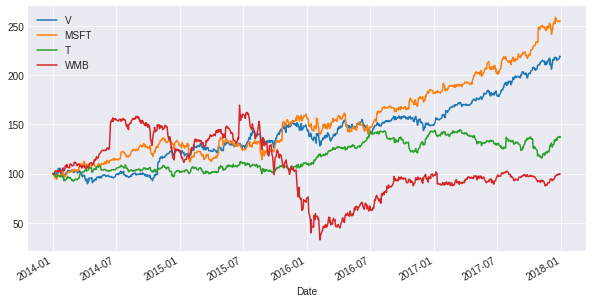

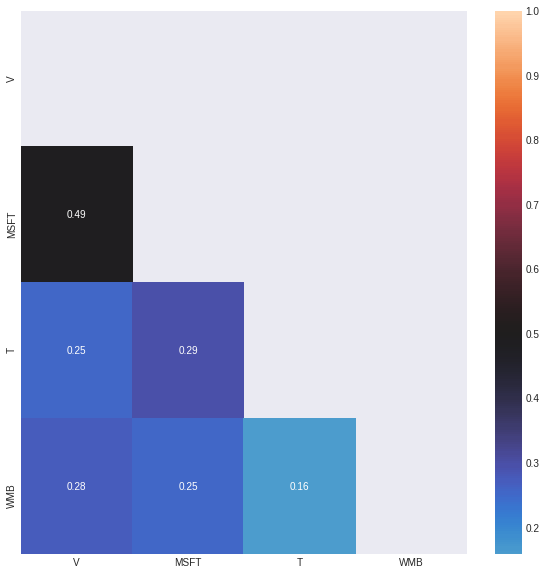

In [88]:
[pf_data, pf_div] = table(assets, start_date, end_date)
display(basic_analysis(pf_data, pf_div))
print((pf_data/pf_data.iloc[0]*100).plot(figsize=(10,5), grid= True))
correlation();

## Montecarlo analysis

Quante combinazioni di portafoglio vuoi generare?
consiglio non più di 20/30 mila per stare in tempi decenti

In [89]:
n_port = 5000

,Weight Sharpe Portfolio [$],Weight Min Variance Portfolio [$]
V,101.2,57.2
MSFT,92.4,22.9
T,6.2,118.3
WMB,0.2,1.6


,Returns,Volatility,Sharpe Ratio,Dividends,Sharpe Yield,Weight_V,Weight_MSFT,Weight_T,Weight_WMB
741,0.2085,0.1738,1.06,25.48,0.042,0.5060,0.4619,0.0310,0.0010
3182,0.1284,0.1327,0.78,45.46,0.017,0.2858,0.1147,0.5917,0.0079


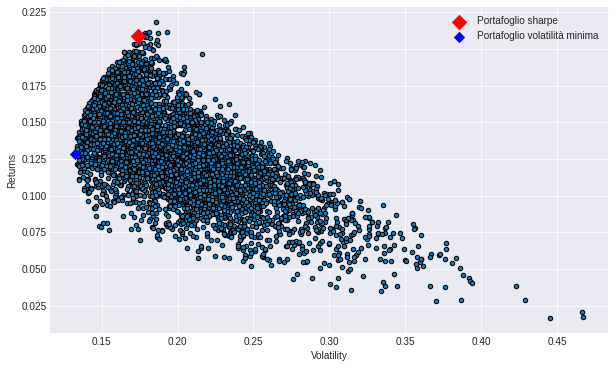

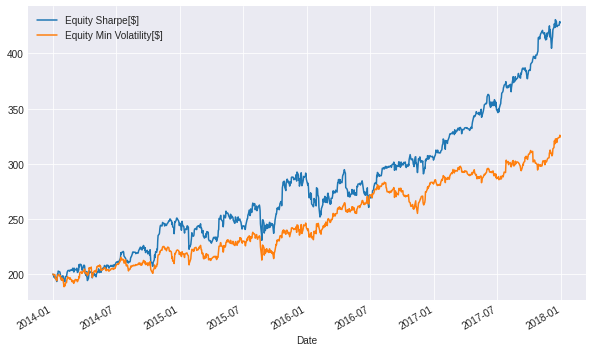

In [90]:
portfoglios = montecarlo(n_port, assets, pf_div,pf_data)
[money_sharpe, money_vol, sharpe_portfolio, min_variance_port] = markowitz(portfoglios)
portfolio_plot(pf_data, money_sharpe, money_vol);

# Validation

Per la validazione consiglio di dividere cosi i dati:
* 70% dati in sample (quindi utilizzati per creare il portafoglio)
* 30% dati out of sample (quindi utilizzati per validare il portafoglio)

esempio:  
utilizzo i dati di 10 anni dal 2010 al 2020
* in sample dal 2010 al 2017
* out of sample dal 2017 al 2020

poi ci sono un sacco di errori concettuali in base alla strategia di investimento che si usa quindi non prendere alla lettera tutto

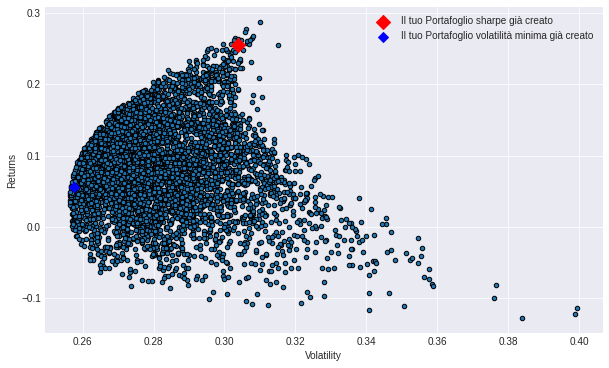

In [97]:
validation(assets,end_date,sharpe_portfolio,min_variance_port)

Possibile inserire un filtro che seleziona solo se si avverano determinate condizioni?  
  es:
* rit > 5%
* vol < 25%

#Analisi sui dividendi
* Dividendo in crescita > inflazione ~2%
* Payout Ratio < 0.65 : dividendi non superiori al 65% utili, deve reinvestire per svilupparsi 
* Utili in crescita: in modo che il divedendo non vada a erodere le riserve 
* Rendimento > 3% : dividends/stock price(odierno) > 3% 
* debito/equity < 1,5: per evitare che i debiti creino problemi sui dividendi 
* beta: meglio se inferiore a S&P (=1), se è più alto vuol dire che è più volatile 